# MANU 465 EEG Project
## Exploring Brainwaves vs Creative and Analytical Tasks
### By: Faith Tan, Emilie Ho, and Pan Tisapramotkul 

## Project Overview and Summary

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Constants used

In [72]:
### CONSTANTS ###

SAMPLING_RATE = 200
CREATIVE_DIR = 'dataset/Drawing/'
MATH_DIR = 'dataset/Mathematical/'

RAW_CHANNEL = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

## Importing Raw Data Collected

In [96]:
import os

# Get all the files path in the mathematical and creative directories appened in a list
math_files = [os.path.join(MATH_DIR, file) for file in os.listdir(MATH_DIR) if os.path.isfile(os.path.join(MATH_DIR, file))]
creative_files = [os.path.join(CREATIVE_DIR, file) for file in os.listdir(CREATIVE_DIR) if os.path.isfile(os.path.join(CREATIVE_DIR, file))]

## Data Preprocessing 

This is a SAMPLE way on how to perform FFT transform from the **raw data in microvolts** collected by MUSE Monitor

MUSE Monitor has 4 electrodes (TF9,AF7,AF8,TP10) that collects data as explained here: https://mind-monitor.com/Technical_Manual.php#help_graph_raw

The example below perform FFT on **AF7** data collected. 

After performing FFT, the peaks, amplitude, and area under the curve maybe be considered to use as features for ML models

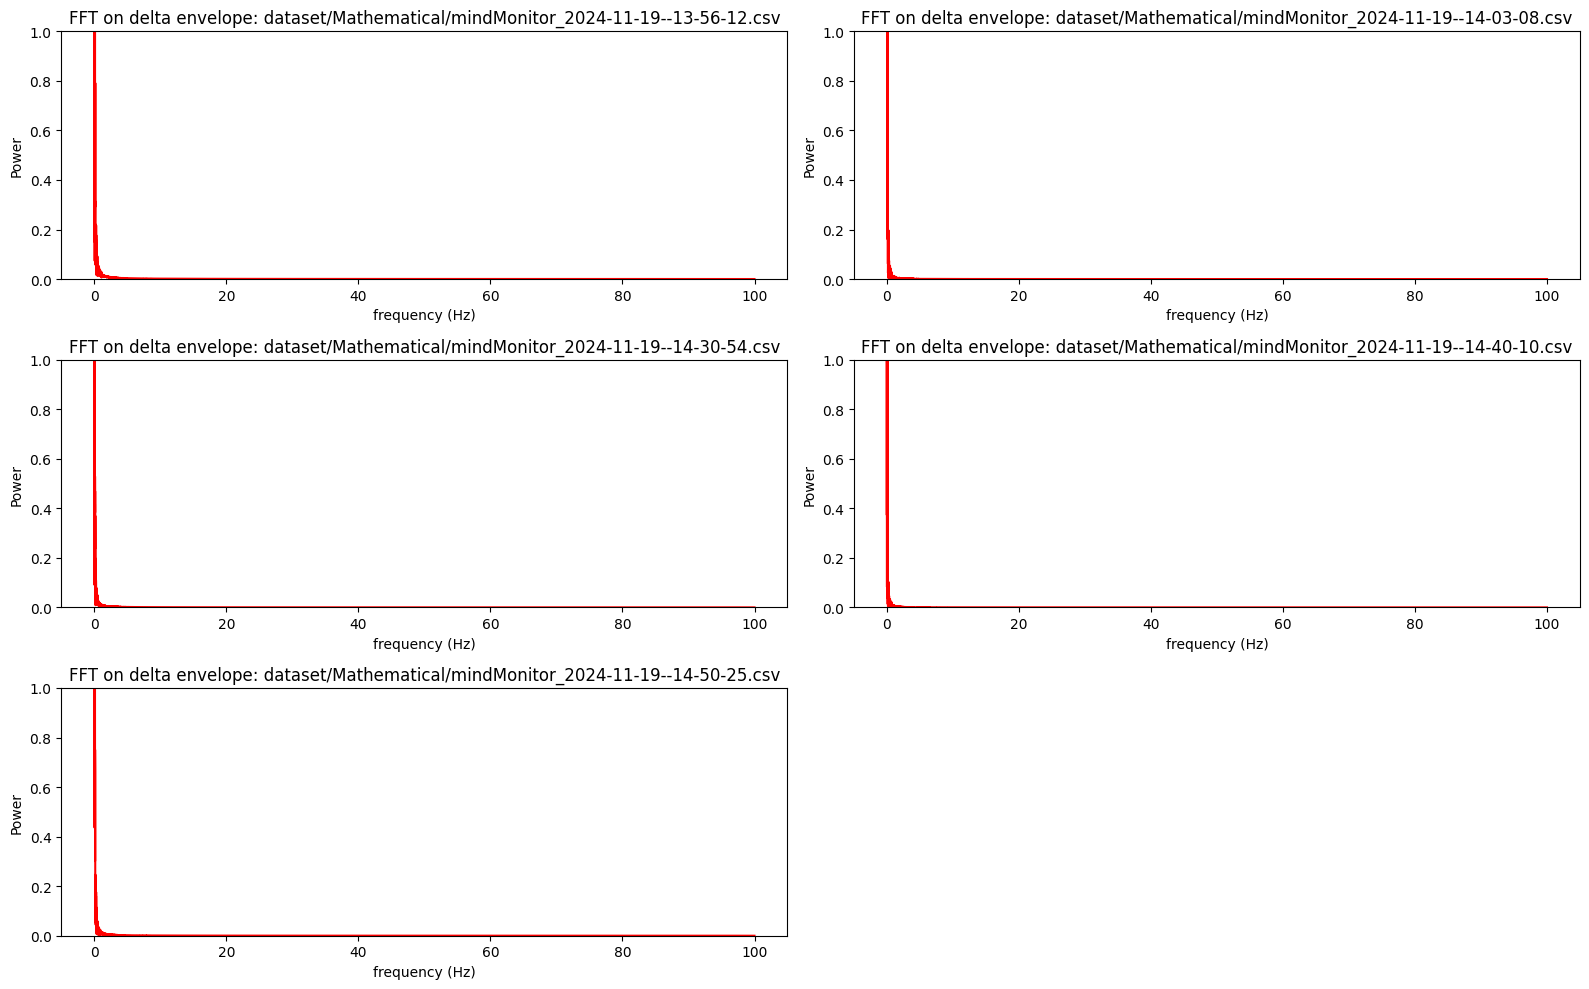

In [99]:
## PLOTTING THE FFT OF THE RAW_AF7 DATA ##
from scipy.signal import hilbert

def cleaned_up_data(file : str):
    # get a dataframe
    dataset = pd.read_csv(file)
    # drop columns and NaN values
    dataset.drop(columns=['Battery','Elements'], inplace=True)
    dataset = dataset.dropna()

    dataset['Delta_Average'] = ((dataset['Delta_TP9'] + dataset['Delta_TP10'] + dataset['Delta_AF7'] + dataset['Delta_AF8']) / 4) * 100
    dataset['Gamma_Average'] = ((dataset['Gamma_TP9'] + dataset['Gamma_TP10'] + dataset['Gamma_AF7'] + dataset['Gamma_AF8']) / 4) * 100
    dataset['Theta_Average'] = ((dataset['Theta_TP9'] + dataset['Theta_TP10'] + dataset['Theta_AF7'] + dataset['Theta_AF8']) / 4) * 100
    dataset['Alpha_Average'] = ((dataset['Alpha_TP9'] + dataset['Alpha_TP10'] + dataset['Alpha_AF7'] + dataset['Alpha_AF8']) /4) * 100
    dataset['Beta_Average'] = ((dataset['Beta_TP9'] + dataset['Beta_TP10'] + dataset['Beta_AF7'] + dataset['Beta_AF8']) / 4 ) * 100
    
    dataset['delta_smooth_data'] = moving_average(dataset['Delta_Average'].values, 1000)
    dataset['delta_envelope'] = np.abs(hilbert(dataset['delta_smooth_data'].values))
    return dataset

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def visualize_data(math=True):
    plt.figure(figsize=(16, 10)) 

    if math:
        file = math_files

    else:
        file = creative_files

    for i, data in enumerate(file):
        dataset = cleaned_up_data(data)
        dataset = dataset['delta_envelope']

        # Perform FFT 
        n = len(dataset)                 # length of the signal
        k = np.arange(n)
        T = n/SAMPLING_RATE
        frq = k/T                 # two sides frequency range
        zz=int(n/2)

        freq = frq[range(zz)]           # one side frequency range
        Y = np.fft.fft(dataset)/n              # fft computing and normalization
        Y = Y[range(zz)]

        plt.subplot(3, 2, i+1)
        plt.plot(freq, abs(Y), 'r-')
        plt.xlabel('frequency (Hz)')
        plt.ylabel('Power')
        plt.ylim(0, 1)
        # plt.xlim(0.5, 50)
        plt.title("FFT on delta envelope: " + data)

    plt.tight_layout()
    plt.show()

def plot_data():
    dataset = cleaned_up_data(math_files[0])

    dataset.plot(x='TimeStamp', 
        y=['delta_smooth_data', 'Delta_Average', 'delta_envelope'], 
        markersize=8, 
        linewidth=1.0)

visualize_data(math=True)

## Feature Extraction

Get the peaks' amplitude, frequency, and area under the curve from the raw data collected by the four electrodes

In [92]:
from scipy.signal import find_peaks
from numpy import trapezoid #type: ignore

def get_fft(dataset, channel : str):
    """Perform FFT on the data of the channel specfied from the range of 0.5 to 50 Hz

    Args:
        dataset (pd.DataFrame): _description_
        channel (str): _description_

    Returns:
        _type_: _description_
    """
    dataset = dataset[channel]

    # Perform FFT 
    n = len(dataset)                 # length of the signal
    k = np.arange(n)
    T = n/SAMPLING_RATE
    frq = k/T                 # two sides frequency range
    zz=int(n/2)

    freq = frq[range(zz)]           # one side frequency range
    Y = np.fft.fft(dataset)/n              # fft computing and normalization
    Y = abs(Y[range(zz)])

    # get only frequency from 0.5 to 50 Hz
    freq_mask = (freq>0.5) & (freq<50)
    filtered_freq = freq[freq_mask]
    filtered_Y = Y[freq_mask]

    print("Length of freq: ", len(filtered_freq))
    
    return filtered_freq, filtered_Y
    
def get_peaks(filtered_freq, filtered_Y):
    if max(filtered_freq) > 60:
        print("Warning: Detected frequency Higher than 60 Hz. Please remove it before continuing")
        return 
    
    # Get the peaks
    peaks, properties = find_peaks(filtered_Y, height=10)

    return [filtered_freq[i] for i in peaks], properties['peak_heights']

def get_area(filtered_Y):
    return trapezoid(abs(filtered_Y), dx=1)

def feature_extraction():
    feature_data = []

    # for each file 
    for i, file in enumerate(math_files[0:2]):
        # initialize lists
        peaks_list = []
        amplitude_list = []
        area_list = []

        # get a cleaned up dataframe
        dataset = cleaned_up_data(file)

        # extract data from electrodes
        for channel in RAW_CHANNEL:
            freq, y = get_fft(dataset, channel)
            peaks, peak_heights = get_peaks(freq, y) # type: ignore
            area = get_area(y)

            peaks_list.extend(peaks)
            amplitude_list.extend(peak_heights)
            area_list.append(area)

            print("File {} channel {} has {} peaks".format(file, channel, len(peaks)))

        # extract data from brainwaves
        for channel in ['Delta_Average', 'Gamma_Average', 'Theta_Average', 'Alpha_Average', 'Beta_Average']:
            freq, y = get_fft(dataset, channel)
            peaks, peak_heights = get_peaks(freq, y) # type: ignore

            peaks_list.extend(peaks)
            amplitude_list.extend(peak_heights)

            print("File {} channel {} has {} peaks".format(file, channel, len(peaks)))

        file_info = [file] + peaks_list + amplitude_list + area_list
        feature_data.append(file_info)

    # Convert to DataFrame
    feature_data = pd.DataFrame(feature_data)

    return feature_data

feature_extraction()
# TODO: only extract the 5 highest peaks 

Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel RAW_AF7 has 11 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel RAW_AF8 has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel RAW_TP9 has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel RAW_TP10 has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel Delta_Average has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel Gamma_Average has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel Theta_Average has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2024-11-19--13-56-12.csv channel Alpha_Average has 0 peaks
Length of freq:  11672
File dataset/Mathematical/mindMonitor_2

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,dataset/Mathematical/mindMonitor_2024-11-19--1...,8.333333,13.329092,16.666667,18.744699,25.00000,26.658185,33.333333,35.411366,39.987277,...,12.518936,36.801635,12.458454,10.058215,16.0479,22.311178,9453.239212,715.021225,1306.581667,1657.756995
1,dataset/Mathematical/mindMonitor_2024-11-19--1...,8.334663,13.329078,16.666667,18.746343,25.00133,33.333333,46.875166,23.125164,21.781727,...,1628.875952,1765.709822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Envolope the Alpha, Beta, Theta, Gamma Curves

## Exploratory Data Analysis

### Splitting Dateset into the Training and Test Sets

### Feature Scaling

### Principal Component Analysis (PCA)

## Building Machine Learning Models

### Classification: Support Vector Machine (SVM)

In [4]:
# from sklearn.svm import SVC

# classifier = SVC(kernel = 'rbf', random_state = 0) // try differernals and remove the random_state maybe
# classifier.fit(X_train, y_train)

### SVM: Confusion Matrix

In [3]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")

### SVM: Prediction a new Result

### Neural Network (ANN) Model